# Youtube Data Analytics 

#  Cleaning and Standardizing Dataset

In [1]:
import pandas as pd
import numpy as np
import os

# Define the data directory path
data_path = 'data'

# List CSV files from different regions
files = [f for f in os.listdir(data_path) if f.endswith('.csv')]

# Create an empty list to hold all dataframes
df_list = []

# Loop through each file
for file in files:
    region = file[:2].upper()  # 'USvideos.csv' -> 'US'
    df = pd.read_csv(os.path.join(data_path, file), encoding='latin-1')

    # Add a 'region' column
    df['region'] = region

    # Standardize column names (lowercase and underscores)
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

    # Parse dates
    if 'trending_date' in df.columns:
        df['trending_date'] = pd.to_datetime(df['trending_date'], errors='coerce', format='%y.%d.%m')
    if 'publish_time' in df.columns:
        df['publish_time'] = pd.to_datetime(df['publish_time'], errors='coerce')

    # Drop duplicates
    df.drop_duplicates(inplace=True)

    # Handle missing values (optional: drop or fill)
    df = df.dropna(subset=['title', 'views', 'likes'])  # drop rows with missing critical fields

    df_list.append(df)

# Combine all country datasets into one
combined_df = pd.concat(df_list, ignore_index=True)

# Optional: reset index and drop unused columns
combined_df.reset_index(drop=True, inplace=True)

# Show basic info
print("Combined Data Shape:", combined_df.shape)
print("Missing values per column:\n", combined_df.isnull().sum())

# Save cleaned file
combined_df.to_csv('cleaned_youtube_trending.csv', index=False, encoding='utf-8-sig')

combined_df.head()

Combined Data Shape: (363372, 17)
Missing values per column:
 video_id                      0
trending_date                 0
title                         0
channel_title                 0
category_id                   0
publish_time                  0
tags                          0
views                         0
likes                         0
dislikes                      0
comment_count                 0
thumbnail_link                0
comments_disabled             0
ratings_disabled              0
video_error_or_removed        0
description               18681
region                        0
dtype: int64


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,region
0,n1WpP7iowLc,2017-11-14,Eminem - Walk On Water (Audio) ft. BeyoncÃ©,EminemVEVO,10,2017-11-10 17:00:03+00:00,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787425,43420,125882,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. BeyoncÃ© ...,CA
1,0dBIkQ4Mz1M,2017-11-14,PLUSH - Bad Unboxing Fan Mail,iDubbbzTV,23,2017-11-13 17:00:00+00:00,"plush|""bad unboxing""|""unboxing""|""fan mail""|""id...",1014651,127794,1688,13030,https://i.ytimg.com/vi/0dBIkQ4Mz1M/default.jpg,False,False,False,STill got a lot of packages. Probably will las...,CA
2,5qpjK5DgCt4,2017-11-14,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12 19:05:24+00:00,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146035,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO â¶ \n\nSUBSCRIBE âº ...,CA
3,d380meD0W0M,2017-11-14,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12 18:01:41+00:00,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095828,132239,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...,CA
4,2Vv-BfVoq4g,2017-11-14,Ed Sheeran - Perfect (Official Music Video),Ed Sheeran,10,2017-11-09 11:04:14+00:00,"edsheeran|""ed sheeran""|""acoustic""|""live""|""cove...",33523622,1634130,21082,85067,https://i.ytimg.com/vi/2Vv-BfVoq4g/default.jpg,False,False,False,ð§: https://ad.gt/yt-perfect\nð°: https://...,CA


Avoiding the nulls in description as they are irrelevant for analysis

# Sentiment Analysis

In [2]:
!pip install textblob

In [3]:
from textblob import TextBlob

# Example: apply sentiment on video titles
def get_sentiment(text):
    blob = TextBlob(str(text))
    return blob.sentiment.polarity  # range from -1 to +1

# Apply sentiment analysis to titles
combined_df['title_sentiment'] = combined_df['title'].apply(get_sentiment)

# Optional: Add a sentiment label
def label_sentiment(score):
    if score > 0.1:
        return 'positive'
    elif score < -0.1:
        return 'negative'
    else:
        return 'neutral'

combined_df['sentiment_label'] = combined_df['title_sentiment'].apply(label_sentiment)

# Preview
combined_df[['title', 'title_sentiment', 'sentiment_label']].head()


,title,title_sentiment,sentiment_label
0,Eminem - Walk On Water (Audio) ft. BeyoncÃ©,0.0,neutral
1,PLUSH - Bad Unboxing Fan Mail,-0.7,negative
2,"Racist Superman | Rudy Mancuso, King Bach & Le...",0.0,neutral
3,I Dare You: GOING BALD!?,0.0,neutral
4,Ed Sheeran - Perfect (Official Music Video),1.0,positive


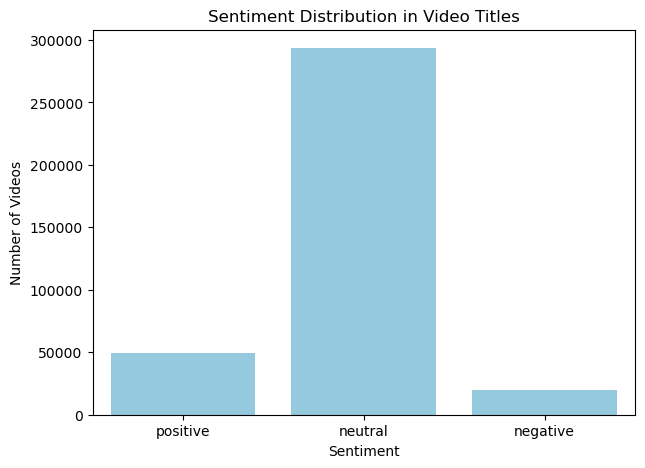

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
sns.countplot(data=combined_df, x='sentiment_label', order=['positive', 'neutral', 'negative'], color='skyblue')
plt.title("Sentiment Distribution in Video Titles")
plt.xlabel("Sentiment")
plt.ylabel("Number of Videos")
plt.show()



In [5]:

# Handle missing or empty tags
combined_df['tags'] = combined_df['tags'].fillna('')

# Define sentiment function
def get_tag_sentiment(tag_text):
    blob = TextBlob(str(tag_text))
    return blob.sentiment.polarity

# Apply function to tags column
combined_df['tag_sentiment'] = combined_df['tags'].apply(get_tag_sentiment)

# Label the sentiment
def label_tag_sentiment(score):
    if score > 0.1:
        return 'positive'
    elif score < -0.1:
        return 'negative'
    else:
        return 'neutral'

combined_df['tag_sentiment_label'] = combined_df['tag_sentiment'].apply(label_tag_sentiment)

# Preview results
combined_df[['tags', 'tag_sentiment', 'tag_sentiment_label']].head()


,tags,tag_sentiment,tag_sentiment_label
0,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",0.000000,neutral
1,"plush|""bad unboxing""|""unboxing""|""fan mail""|""id...",0.150000,positive
2,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",0.111111,positive
3,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",-0.350000,negative
4,"edsheeran|""ed sheeran""|""acoustic""|""live""|""cove...",0.136364,positive


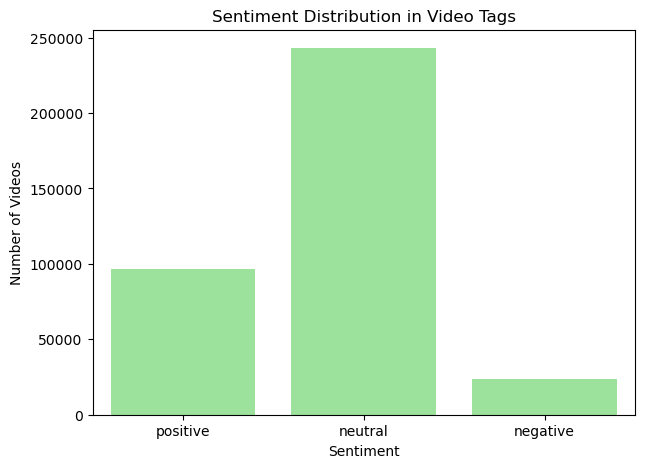

In [6]:
plt.figure(figsize=(7, 5))
sns.countplot(data=combined_df, x='tag_sentiment_label', order=['positive', 'neutral', 'negative'], color='lightgreen')
plt.title("Sentiment Distribution in Video Tags")
plt.xlabel("Sentiment")
plt.ylabel("Number of Videos")
plt.show()


In [7]:
title_sentiment_stats = combined_df.groupby('sentiment_label')[['views', 'likes']].mean().reset_index()
print(title_sentiment_stats)


  sentiment_label         views         likes
0        negative  3.221194e+06  80494.413802
1         neutral  1.183638e+06  34479.279794
2        positive  1.527000e+06  44650.841136


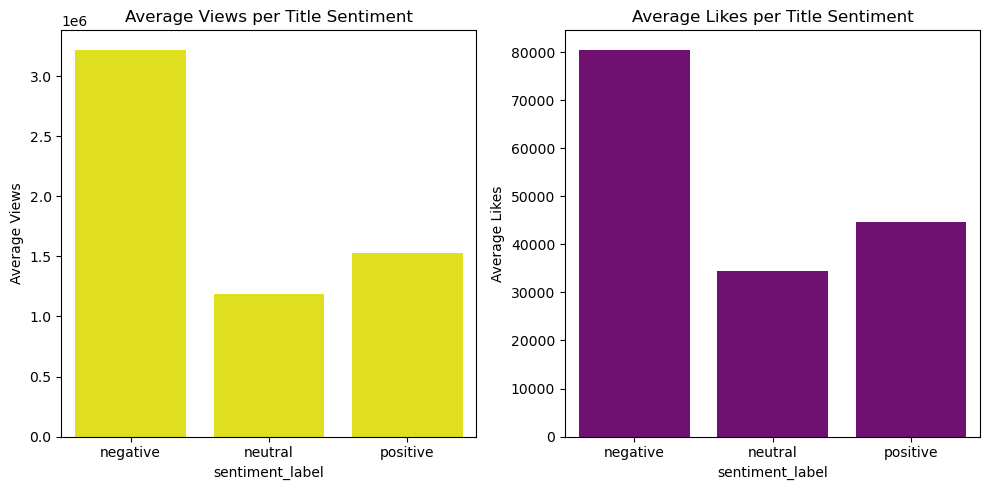

In [8]:
plt.figure(figsize=(10, 5))

# Views
plt.subplot(1, 2, 1)
sns.barplot(data=title_sentiment_stats, x='sentiment_label', y='views', color='yellow')
plt.title("Average Views per Title Sentiment")
plt.ylabel("Average Views")

# Likes
plt.subplot(1, 2, 2)
sns.barplot(data=title_sentiment_stats, x='sentiment_label', y='likes', color='purple')
plt.title("Average Likes per Title Sentiment")
plt.ylabel("Average Likes")

plt.tight_layout()
plt.show()


In [9]:
tag_sentiment_stats = combined_df.groupby('tag_sentiment_label')[['views', 'likes']].mean().reset_index()
print(tag_sentiment_stats)


  tag_sentiment_label         views         likes
0            negative  3.274062e+06  84207.401735
1             neutral  1.031198e+06  30684.518307
2            positive  1.651873e+06  46565.018095


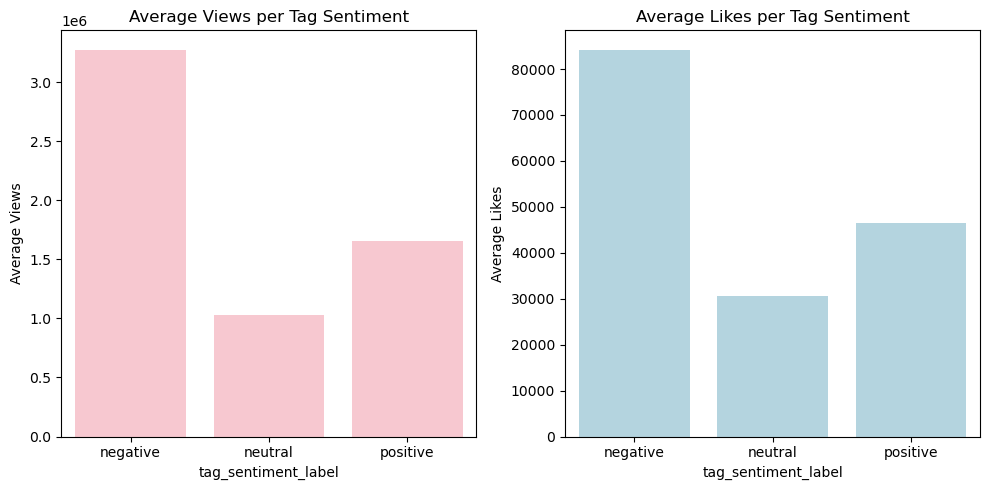

In [10]:
plt.figure(figsize=(10, 5))

# Views
plt.subplot(1, 2, 1)
sns.barplot(data=tag_sentiment_stats, x='tag_sentiment_label', y='views', color='pink')
plt.title("Average Views per Tag Sentiment")
plt.ylabel("Average Views")

# Likes
plt.subplot(1, 2, 2)
sns.barplot(data=tag_sentiment_stats, x='tag_sentiment_label', y='likes', color='lightblue')
plt.title("Average Likes per Tag Sentiment")
plt.ylabel("Average Likes")

plt.tight_layout()
plt.show()


In [11]:
correlation = combined_df[['title_sentiment', 'views', 'likes']].corr()
print(correlation)


                 title_sentiment     views     likes
title_sentiment         1.000000 -0.021894 -0.007308
views                  -0.021894  1.000000  0.779384
likes                  -0.007308  0.779384  1.000000


# SQL Analysis 

In [12]:
!pip install pandasql

In [13]:
import pandasql as ps

In [14]:
# This will rank category_id by average views
query = """
SELECT category_id, AVG(views) AS avg_views
FROM combined_df
GROUP BY category_id
ORDER BY avg_views DESC
LIMIT 10;
"""

top_categories_views = ps.sqldf(query, locals())
top_categories_views

,category_id,avg_views
0,10,6.094538e+06
1,30,1.774643e+06
2,1,1.327032e+06
3,28,1.115871e+06
4,24,9.635065e+05
5,23,8.203270e+05
6,17,8.078187e+05
7,20,6.818134e+05
8,26,5.204091e+05
9,43,4.430091e+05


In [15]:
query_likes = """
SELECT category_id, AVG(likes) AS avg_likes
FROM combined_df
GROUP BY category_id
ORDER BY avg_likes DESC
LIMIT 10;
"""

top_categories_likes = ps.sqldf(query_likes, locals())
top_categories_likes

,category_id,avg_likes
0,10,171562.539803
1,23,40245.188442
2,29,33744.057824
3,28,30534.580813
4,1,28467.353885
5,20,26612.778360
6,24,26483.093509
7,30,25083.866667
8,26,18614.234882
9,17,17095.653831


In [16]:
query_comments = """
SELECT category_id, AVG(comment_count) AS avg_comments
FROM combined_df
GROUP BY category_id
ORDER BY avg_comments DESC
LIMIT 10;
"""

top_categories_comments = ps.sqldf(query_comments, locals())
top_categories_comments

,category_id,avg_comments
0,10,14619.448787
1,29,9713.973979
2,28,5546.878904
3,20,4343.774473
4,23,4106.011658
5,24,3801.572332
6,1,3165.432625
7,26,2637.159480
8,17,2010.046364
9,22,1903.338547


# Map category_id to category_name for All Countries

In [18]:
import os
import json
import pandas as pd

# Step 1: Create a dictionary to hold all mappings
all_category_mappings = {}

# Step 2: Loop through all JSON files in 'data' folder
json_files = [f for f in os.listdir('data') if f.endswith('_category_id.json')]

for file in json_files:
    region_code = file[:2].upper()  # Extract 'US', 'IN', etc.
    
    with open(os.path.join('data', file), 'r') as f:
        data = json.load(f)
        
        # Extract id-name mapping
        for item in data['items']:
            cat_id = int(item['id'])
            cat_name = item['snippet']['title']
            
            # Store by region+category_id to allow unique matching
            all_category_mappings[(region_code, cat_id)] = cat_name

# Define a function to look up category name based on (region, category_id)
def get_category_name(row):
    return all_category_mappings.get((row['region'], int(row['category_id'])), 'Unknown')

# Apply to combined_df
combined_df['category_name'] = combined_df.apply(get_category_name, axis=1)

combined_df.to_csv('final_youtube_data_for_tableau.csv', index=False, encoding='utf-8-sig')
